In [1]:
import matplotlib.pyplot as plt

# Simple utility function to display image comparisons
def side_by_side(left, right):
    plt.figure(figsize=(15, 10))

    plt.subplot(121)
    plt.imshow(left, cmap='gray')

    plt.subplot(122)
    plt.imshow(right, cmap='gray')
    
    plt.show()

## Camera Calibration

In [2]:
from glob import glob
import numpy as np
import cv2

object_points = []
image_points = []
for pathname in glob('camera_cal/*.jpg'):
    image = cv2.imread(pathname, cv2.IMREAD_GRAYSCALE)
    ret, corners = cv2.findChessboardCorners(image, (9, 6))
    
    # Check if all corners have been detected
    if ret == 0: continue
    
    object_points.append([
        [0., 0., 0.], [8., 0., 0.],
        [0., 5., 0.], [8., 5., 0.],
    ])
    
    image_points.append([
        corners[0][0], corners[8][0], 
        corners[45][0], corners[53][0]
    ])

object_points = np.array(object_points, dtype=np.float32)
image_points = np.array(image_points, dtype=np.float32)
    
ret, cmtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, image.shape[::-1], None, None)

## Lane detection pipeline

### Distortion correction

In this first step, we correct for distortions introduced by the camera lenses. This is possible thanks to camera calibration we did earlier.

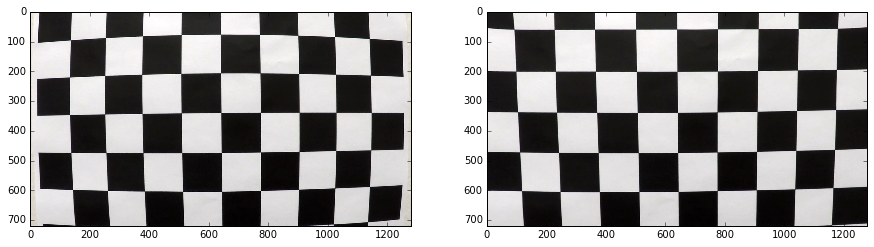

In [3]:
def undistort(img):
    return cv2.undistort(image, cmtx, dist)

image = cv2.imread('camera_cal/calibration1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

undistorted = undistort(image)

side_by_side(image, undistorted)

### Image binarization (thresholding)

Binarize the image to extract pixels belonging to lane lines.

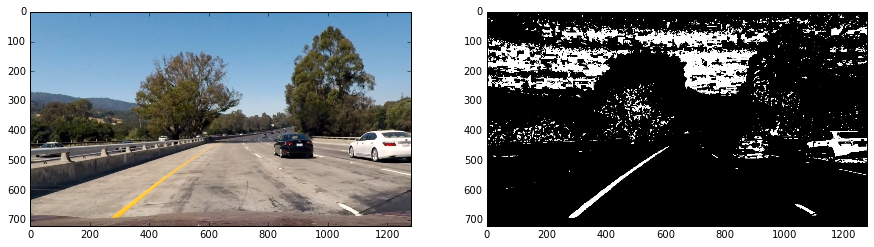

In [4]:
def binarize(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    stn = hls[:, :, 2]

    stn_mask = np.zeros_like(stn)
    stn_mask[stn >= 128] = 1

    return np.uint8(stn_mask * 255)

image = cv2.imread('test_images/test1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted = cv2.undistort(image, cmtx, dist)

side_by_side(undistorted, binarize(undistorted))

## Perspective transform

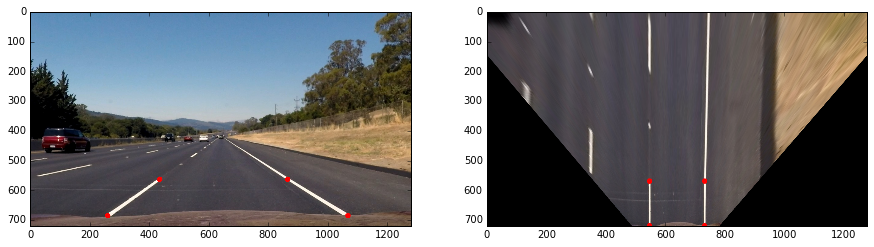

In [5]:
# One meter equals 50 pixels in the image
# We will use that in later computation
SCALE = 50

src = np.float32([
    [260, 685],
    [434, 563],
    [863, 563],
    [1065, 685],
]) 

dst = np.float32([
    [546, 719],
    [546, 569],
    [731, 569],
    [731, 719]
])

M = cv2.getPerspectiveTransform(src, dst)

def warp(img):
    return cv2.warpPerspective(img, M, undistorted.shape[1::-1])

def unwarp(img):
    return cv2.warpPerspective(img, M, undistorted.shape[1::-1], flags=cv2.WARP_INVERSE_MAP)

image = cv2.imread('test_images/straight_lines2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted = cv2.undistort(image, cmtx, dist)

warped = warp(undistorted)

for point in src:
    cv2.circle(undistorted, tuple(point), 9, (255, 0, 0), -1)

for point in dst:
    cv2.circle(warped, tuple(point), 9, (255, 0, 0), -1)

side_by_side(undistorted, warped)

### Indentify lane-line pixels

#### Step one: localize histogram peaks at the bottom half of the image

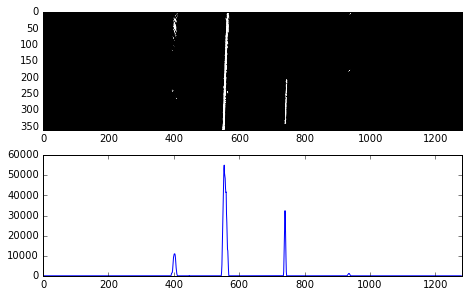

In [6]:
def histogram_peaks(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0] // 2:, :], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] // 2)
    left_peak = np.argmax(histogram[:midpoint])
    right_peak = np.argmax(histogram[midpoint:]) + midpoint
    
    return left_peak, right_peak, histogram

image = cv2.imread('test_images/test3.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted = cv2.undistort(image, cmtx, dist)
binary = binarize(undistorted)
binary_warped = warp(binary)

left_peak, right_peak, hist = histogram_peaks(binary_warped)

plt.figure(figsize=(7.5, 4.75))

plt.subplot(211)
plt.imshow(binary_warped[359:, :], cmap='gray')

plt.subplot(212)
plt.plot(hist)
plt.gca().set_xlim(0, 1280)
plt.show()

#### Step two: classify lane-line pixels using sliding window computation

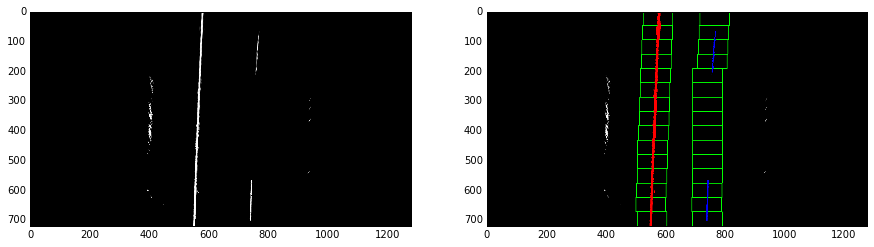

In [7]:
def sliding_window(img, leftx_base, rightx_base):
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 15
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Store history of window positions for each side of the lane
    windows = [[], []]
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0] // nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        
        # Save windows' locations
        windows[0].append([
            [win_xleft_low, win_y_low],
            [win_xleft_high, win_y_high]
        ])
        windows[1].append([
            [win_xright_low, win_y_low],
            [win_xright_high, win_y_high]
        ])
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.mean(nonzerox[good_left_inds], dtype=np.int32)
        
        if len(good_right_inds) > minpix:
            rightx_current = np.mean(nonzerox[good_right_inds], dtype=np.int32)

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, windows

leftx, lefty, rightx, righty, windows = sliding_window(binary_warped, left_peak, right_peak)

visualization = np.dstack([binary_warped, binary_warped, binary_warped])

# Store locations of right and left windows in a single sequence
windows = np.concatenate(windows)

# Draw the windows on the visualization image
for window in windows:
    cv2.rectangle(visualization, tuple(window[0]), tuple(window[1]), (0, 255, 0), 2)

# Highlight the pixels classified into each line
visualization[lefty, leftx] = [255, 0, 0]
visualization[righty, rightx] = [0, 0, 255]

leftx, lefty, rightx, righty, windows = sliding_window(binary_warped, left_peak, right_peak)
side_by_side(binary_warped, visualization)

#### Step three: fit a second degree polynomial to each set of points

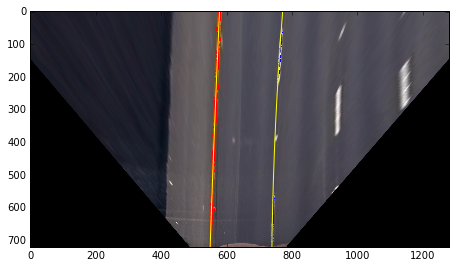

In [8]:
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
try:
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
except TypeError:
    # Avoids an error if `left` and `right_fit` are still none or incorrect
    print('The function failed to fit a line!')
    left_fitx = 1*ploty**2 + 1*ploty
    right_fitx = 1*ploty**2 + 1*ploty

visualization = warp(undistorted)

# Highlight the pixels classified into each line
visualization[lefty, leftx] = [255, 0, 0]
visualization[righty, rightx] = [0, 0, 255]

# Plots the left and right polynomials on the lane lines
plt.figure(figsize=(7.5, 4.75))
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(visualization)
plt.show()

### Calculate the radius of curvature

Given the polynomial curve as: $f(y) = Ay^2 + By + C$, we calculate radius of the curve at point $\left(f(y), y\right)$ with the following equation:

$$
R_{curve} = \frac{\left(1 + \left(2Ay + B\right)^2\right)^{1.5}}{\left|2A\right|}
$$

In [9]:
def _radius_of_curvature(fit, y_eval):
    return (1 + (2*fit[0]*y_eval + fit[1])**2)**1.5 / np.abs(2*left_fit[0]) / SCALE

def radii_of_curvature(left_fit, right_fit, y_eval):
    return _radius_of_curvature(left_fit, y_eval), \
            _radius_of_curvature(right_fit, y_eval)

curv = radii_of_curvature(left_fit, right_fit, 719)

print('Radii of curvature for both lines (in meters): {}'.format(curv))

Radii of curvature for both lines (in meters): (1184.2481250560757, 1182.5432267961623)


### Calculate position of the vehicle with respect to lane center

In [10]:
def _eval(fit, y):
    return fit[0] * y**2 + fit[1]*y + fit[2]

def distance_from_center(left_fit, right_fit, y_eval):
    left_x = _eval(left_fit, y_eval)
    right_x = _eval(right_fit, y_eval)
    center_x = (left_x + right_x) / 2
    
    vehicle_x = 639
    
    return np.abs(vehicle_x - center_x) / SCALE

dist = distance_from_center(left_fit, right_fit, 719)

print('Estimated distance from lane center (in meters): {} m'.format(dist))

Estimated distance from lane center (in meters): 0.1000620148320786 m


### Plot the result back on the road

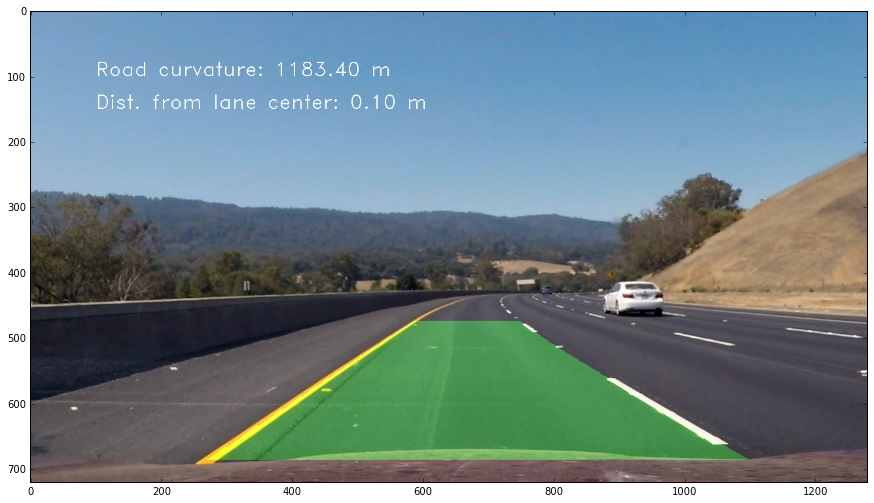

In [11]:
def display_results(img, left_fitx, right_fitx, curv, dist):
    warped_overlay = np.zeros_like(undistorted)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(warped_overlay, np.int_([pts]), (0, 255, 0))

    overlay = unwarp(warped_overlay)
    out_img = cv2.addWeighted(undistorted, 1, overlay, 0.3, 0)

    out_img = cv2.putText(out_img, 'Road curvature: {:.2f} m'.format(np.mean(curv)), (100, 100),
                          cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255))
    out_img = cv2.putText(out_img, 'Dist. from lane center: {:.2f} m'.format(dist), (100, 150),
                          cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255))
    
    return out_img

display = display_results(undistorted, left_fitx, right_fitx, curv, dist)

plt.figure(figsize=(15, 10))
plt.imshow(display)
plt.show()